In [2]:


# Define colors
colors = {
    "Single": "#333333",
    "Left": "#246EB9",
    "Right": "#8B1E3F",
    "Ipsilateral": "#1B9E77",
    "Contralateral": "#D95F02",
    "Within": "#2B4162",
    "Across": "#E89D0B",
    'SerialBiasWeak': '#254441',
    'SerialBias': '#43AA8B',\
    'ReactivationWeak': '#7A8A99',
    'Reactivation': '#12719E'
}

from matplotlib.colors import LinearSegmentedColormap
left_right_cmap = LinearSegmentedColormap.from_list("LeftRight",\
                                                     [colors['Left'], "white", colors['Right']])
ipsi_contra_cmap = LinearSegmentedColormap.from_list("IpsiContra",\
                                                     [colors['Ipsilateral'], "white", colors['Contralateral']])
within_cmap = LinearSegmentedColormap.from_list("Within",\
                                                     ["white", colors['Within']])
across_cmap = LinearSegmentedColormap.from_list("Across",\
                                                     ["white", colors['Across']])

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cmath import phase
from scipy.stats import circmean, sem
import random
from ast import literal_eval
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib

def len2(x):
	if type(x) is not type([]):
		if type(x) is not type(np.array([])):
			return -1
	return len(x)

def phase2(x):
	if not np.isnan(x):
		return phase(x)
	return np.nan

def circdist(angles1,angles2):
    if len2(angles2) < 0:
        if len2(angles1) > 0:
            angles2 = [angles2]*len(angles1)
        else:
            angles2 = [angles2]
            angles1 = [angles1]
        if len2(angles1) < 0:
            angles1 = [angles1]*len(angles2)
    return np.array(list(map(lambda a1,a2: phase2(np.exp(1j*a1)/np.exp(1j*a2)), angles1,angles2)))

def sig_bar(sigs,axis,y,ax,color):
	w=np.diff(axis)[0]
	for s in sigs:
		beg =axis[s]-w/2
		end = axis[s]+w/2
		ax.fill_between([beg,end],[y[0],y[0]],[y[1],y[1]],color=color)
        
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array-value)).argmin()
    return idx

def normgauss(xxx,sigma):
    gauss = (1/(sigma*np.sqrt(2*np.pi)) *np.exp(-(xxx-0)**2 / (2*sigma**2)))
    return gauss/gauss.max()

def normgrad(xxx):
    return np.gradient(xxx)/np.gradient(xxx).max()

def dog1(sigma,x):
    xxx     = np.arange(-2*np.pi, 2*np.pi, .0001) 
    dog_1st = normgrad(normgauss(xxx,sigma))
    return np.array(list(map(lambda x: dog_1st[find_nearest(xxx,x)], x)))

def mov_avg(rel_loc, err, w1, w2, folded):  
    m_err=[]
    std_err=[]
    count=[]
    cis=[]
    x = np.arange(-np.pi,np.pi,w1)
    if folded:
        err = np.array([np.sign(rel_loc[i])*err[i] if np.sign(rel_loc[i])!=0 else err[i] for i in range(len(err))])
        rel_loc = np.abs(rel_loc)
        x = np.arange(0,np.pi,w1)
    for i,t in enumerate(x):
        idx=abs(circdist(rel_loc,t)) <= w2/2
        m_err.append(np.mean(err[idx]))
        std_err.append(np.std(err[idx]))
           
    return (x), np.array(m_err),np.array(std_err)


/Users/jbarbosa/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


---

In [4]:
filename = 'model_JB'

df_models = pd.read_csv(filename+'.csv')

df_models['stim1_location_rad'] = np.deg2rad(df_models.stim1_location) -\
                        (np.deg2rad(df_models.stim1_location)>np.pi).astype(int)*2*np.pi
df_models['stim2_location_rad'] = np.deg2rad(df_models.stim2_location) -\
                        (np.deg2rad(df_models.stim2_location)>np.pi).astype(int)*2*np.pi

# response as average from both sides
df_models['response1'] = circmean([df_models['response1_area1'].values, df_models['response1_area2'].values],\
                                  low=-np.pi, high=np.pi, axis=0)
df_models['response2'] = circmean([df_models['response2_area1'].values, df_models['response2_area2'].values],\
                                  low=-np.pi, high=np.pi, axis=0)
df_models['response1Err'] = circdist(df_models.response1.values, (df_models.stim1_location_rad.values))
df_models['response2Err'] = circdist(df_models.response2.values, (df_models.stim2_location_rad.values))

df_models['across_factor_label'] = [str(i*100)+'%' if i>=0 else 'random' for i in df_models['across_factor'].values]
df_models['across_factor'] = [i if i!=-0.01 else 0.014 for i in df_models['across_factor'].values]

# colors
#cmap = matplotlib.cm.get_cmap('autumn_r')
colorsLM = ["#2b4162ff", "#8D9B5E", "#E89D0B", "#EB6424", "#B33B1E", "#7B1F2A"]


DoG_SIGMA=0.6


print('# simulations: '+str(len(df_models)))


# simulations: 8441


In [5]:
# TIMINGS

# indexes of bump average (window=200ms, step=100ms)
index_stim1start = int(np.round((df_models.stim_start.unique()[0]/1000)/df_models.steps.unique()[0]))
index_stim1end = int(np.round(((df_models.stim_start.unique()[0]+df_models.stim_duration[0])/1000)/df_models.steps.unique()[0]))
index_trial1end = int(np.round((df_models.stim2_start.unique()[0]/1000-np.unique(df_models.window)[0])/df_models.steps.unique()[0]))
index_stim2start = int(np.round((df_models.stim2_start.unique()[0]/1000)/df_models.steps.unique()[0]))

#timings in seconds
time_stim1start = df_models.stim_start.unique()[0]/1000 - df_models.window.unique()[0]
time_stim1end = df_models.stim_start.unique()[0]/1000 + (df_models.stim_duration.unique()[0])/1000 

time_reactstart = df_models.react_start.unique()[0]/1000 - df_models.window.unique()[0]
time_reactend = df_models.react_end.unique()[0]/1000 + df_models.window.unique()[0]

time_stim2start = df_models.stim2_start.unique()[0]/1000 - df_models.window.unique()[0]
time_stim2end = df_models.stim2_start.unique()[0]/1000 + (df_models.stim_duration.unique()[0])/1000 




# Serial bias

In [6]:
df_models['prev_curr'] = circdist(df_models.stim1_location_rad.values, df_models.stim2_location_rad.values)
df_models['error2_area1'] = circdist(df_models.response2_area1.values, df_models.stim2_location_rad.values)
df_models['error2_area2'] = circdist(df_models.response2_area2.values, df_models.stim2_location_rad.values)


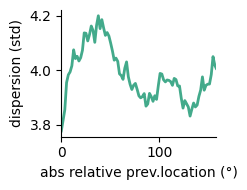

In [7]:
folded=True
w1 = np.pi/100
w2 = np.pi/8


# colors for delay dependence plots
import matplotlib
cmap_delay = matplotlib.cm.get_cmap('RdBu')
colors_delay = ['darkred', 'steelblue']

# compute SD of response (average of both areas)
prevcurr_both = df_models['prev_curr'].values
error_both = df_models['response2Err'].values

x, mov, std_mov = mov_avg(prevcurr_both, error_both, w1, w2, folded)
x, mov, std_mov = np.rad2deg(x), np.rad2deg(mov), np.rad2deg(std_mov)

plt.figure(figsize=(2.4,2.))
# plt.axhline(color='#333333', alpha=0.5)
# plt.axvline(color='#333333', alpha=0.5)
plt.plot(x, std_mov, color=colors['SerialBias'], label='delay', lw=2)
# plt.scatter(np.rad2deg(df.prev_curr), -0.4*dog1(DoG_SIGMA, df.prev_curr))
#plt.fill_between(x, mov -std_mov, mov+std_mov, alpha=0.3, color=colors_delay[0])
plt.xlabel('abs relative prev.location (°)')
plt.ylabel('dispersion (std)')
plt.xlim(0,180-np.rad2deg(w2))
sns.despine()
plt.tight_layout()
